In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [128]:
table = pd.read_csv("table3.csv")
# last column name as target 
TARGET: str = table.columns[-1]

In [129]:
def p_target(x, col: str, classes: list[str]) -> list[float]:
    p_target = []
    for c in classes:
        p_target.append(x[x[col] == c].shape[0] / x.shape[0])
    return p_target


def H(p_target: list[float]) -> float:
    return -sum(p * np.log2(p) if p > 0 else 0 for p in p_target)


def feature_table(x, feature: str, classes: list[str]) -> list[float]:
    table = pd.DataFrame(columns=classes, index=x[feature].unique())
    for c in classes:
        for f in x[feature].unique():
            table.loc[c, f] = x[(x[feature] == f) & (x[TARGET] == c)].shape[0]

    table = table.astype(float).fillna(0)
    return table


def feature_table_entropy(x, HS: float) -> float:
    return HS + -sum(
        [
            x[c].sum()
            / x.sum().sum()
            * H(
                [
                    x.loc[class_, c] / x[c].sum() if x[c].sum() > 0 else 0
                    for class_ in x.index
                ]
            )
            for c in x.columns
        ]
    )


def find_max_feature(
    x, features: list[str], classes: list[str], HS: float
) -> tuple[str, int]:
    feature_entropies = []
    for feature in features:
        feature_table_ = feature_table(x, feature, classes)
        feature_entropies.append(feature_table_entropy(feature_table_, HS))
    return features[np.argmax(feature_entropies)], np.max(feature_entropies)

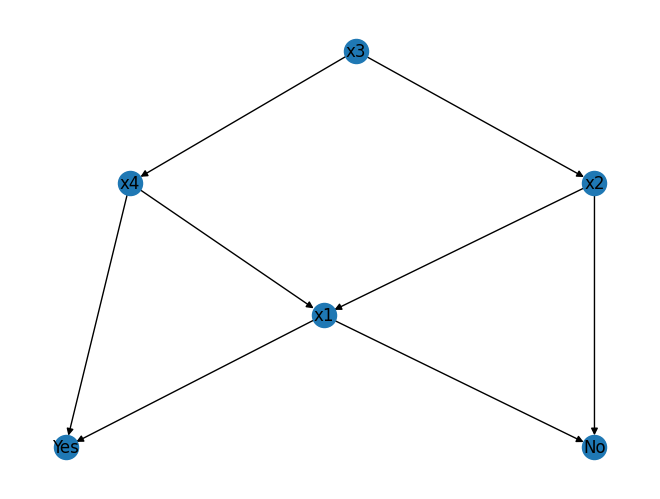

In [130]:
def ID3(
    x,
    features: list[str],
    classes: list[str],
    HS: float,
    parent_node=None,
    value=None,
    G=None,
) -> nx.DiGraph:
    if G is None:
        G = nx.DiGraph()

    # If all examples are in the same class, add a node with the class label
    if len(x[TARGET].unique()) == 1:
        node_label = x[TARGET].iloc[0]
        G.add_node(node_label)
        if parent_node is not None:
            G.add_edge(parent_node, node_label, label=value)
        return G

    # If no features left, return the majority class
    if len(features) == 0:
        node_label = x[TARGET].mode()[0]
        G.add_node(node_label)
        if parent_node is not None:
            G.add_edge(parent_node, node_label, label=value)
        return G
    
    # If no examples left, return the majority class of the parent node
    if x.shape[0] == 0:
        node_label = table[table[TARGET] == parent_node].mode()[0]
        G.add_node(node_label)
        if parent_node is not None:
            G.add_edge(parent_node, node_label, label=value)
        return G

    # Find the best feature
    best_feature, subHS = find_max_feature(x, features, classes, HS)
    G.add_node(best_feature)
    if parent_node is not None:
        G.add_edge(parent_node, best_feature, label=value)

    # Recursively add branches and nodes
    unique_values = x[best_feature].unique()
    for val in unique_values:
        subtable = x[x[best_feature] == val].drop(columns=[best_feature])
        remaining_features = [f for f in features if f != best_feature]
        ID3(subtable, remaining_features, classes, subHS, best_feature, val, G)

    return G


def plot_tree(G: nx.DiGraph):
    # pos = nx.spring_layout(G)
    pos = graphviz_layout(G, prog="dot")
    nx.draw(G, pos, with_labels=True, arrows=True)
    plt.show()


G = ID3(
    table,
    table.columns[:-1].to_list(),
    classes=["Yes", "No"],
    HS=H(p_target(table, TARGET, ["Yes", "No"])),
)
plot_tree(G)